# Yolov3 object detection & collision avoidance

This notebook puts together the model avoidance and yoloV3 based object detection modules.
Both models are Pytorch based.

## Importing libraries and object detection model


In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import time

config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'

img_size=416
conf_thres=0.5
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:47: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


#### Declaring object detection function

In [2]:
def detect_image(img):
    # preprocessing image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])

    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    #return detections
    return detections[0]

#### Declaring function that processes details from detected objects.
With this function, the user can define if he wants to find a specific object or rather all objects that yolov3 is trained on. 
Additionally, the function allows the user to only return coordinates, or additionally plot an image that shows the location of the object in the original image.

In [3]:
# load image and get detections
def find_object(object_name,img,selection='object_only',visualize=False, style='line'):
    prev_time = time.time()
    object_found=False
    #Detecting objects
    detections = detect_image(img)

    inference_time = datetime.timedelta(seconds=time.time() - prev_time)
    
    object_dict={}
    
    if detections is not None:
        start_time = time.time()
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)

        #converting the image to numpy array
        img = np.array(img)
        
        pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
        pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
        unpad_h = img_size - pad_y
        unpad_w = img_size - pad_x
        
        if visualize==True:
            cmap = plt.get_cmap('tab20b')
            colors = [cmap(i) for i in np.linspace(0, 1, 20)]
            bbox_colors = random.sample(colors, n_cls_preds)
            plt.figure()
            fig, ax = plt.subplots(1, figsize=(12,9))
            ax.imshow(img)

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            if selection=='object_only' and classes[int(cls_pred)]!=object_name:
                continue
            else:
                object_found=True
                
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]

            #drawing boxes
            if visualize==True:
                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                
                if style=='box':
                    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
                else:
                    bbox = patches.Rectangle((x1, y1+box_h), box_w, 0, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(bbox)
                plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',bbox={'color': color, 'pad': 0})
                
            object_dict[classes[int(cls_pred)]]=(classes[int(cls_pred)],((x1+box_h).item(),(y1).item()),((x1+box_h+box_w).item(),(y1).item()))
            if object_found:
                break
            
        if visualize==True:
            plt.axis('off')
            plt.show()
            plt.savefig('detection.png')
            
    return object_dict

## Loading the object avoidance model

In [4]:
import torch
import torchvision

model_oa = torchvision.models.alexnet(pretrained=False)
model_oa.classifier[6] = torch.nn.Linear(model_oa.classifier[6].in_features, 2)

#### Loading weights from pre-trained model

In [5]:
model_oa.load_state_dict(torch.load('best_model.pth'))

#### Transferring weights from CPU to GPU for faster processing

In [6]:
device = torch.device('cuda')
model_oa = model_oa.to(device)

#### Creating the preprocess function to match the image specifications that the model was trained on.

In [7]:
import cv2
import numpy as np

mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, stdev)

def preprocess(camera_value):
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

#### Declaring the update function. 
This function is called everytime a frame from the camera is processed. It runs the object avoidance and object detection functions. Any time an obstacle is detected, the turn function is called.

In [8]:
def update(change):
    global blocked_slider, car, frame_counter, going_forward
    
    frame_counter+=1
    x = change['new'] 
    x = preprocess(x)
    y = model_oa(x)
    detections={}
    
    if frame_counter==20:
        car.throttle=-0.1
        time.sleep(0.1)
        detections=find_object('cup',Image.fromarray(camera.value),selection='object_only',visualize=False, style='line')
        if detections:
            print("OBJECT FOUND!")
        frame_counter=0
            
    
    # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    y = F.softmax(y, dim=1)
    
    prob_blocked = float(y.flatten()[0])
    blocked_slider.value = prob_blocked

    if prob_blocked < 0.9:
        car.steering=0
        car.throttle=.55
        going_forward=True
    else:
        if going_forward==True:
            car.thottle=-.7
            time.sleep(0.1)
        frame_counter=0
        car.throttle=0
        time.sleep(0.5)
        detections=turn(random.randint(40,120),random.choice(['left','left']))
        car.throttle=0
        time.sleep(0.5)
        

            
    time.sleep(0.001)
    return detections

#### Declaring the function that turn the robot if it encounters an obstacle. 
The robot analyzes its surroundings for objects at every turn.

In [9]:
import torch.nn.functional as F
import time
frame_counter=0
from PIL import Image
import random


def turn(degrees,direction='left'):
    if direction!='left':
        direction=-1
    else:
        direction=1
    detections={}
    turn_first=-1
    turns_needed=int(degrees/20)
    
    for i in range(turns_needed):
        detections=find_object('cup',Image.fromarray(camera.value),selection='object_only',visualize=False, style='line')
        car.steering=1*direction
        time.sleep(0.3)
        car.throttle=0.7*turn_first
        time.sleep(0.37)
        car.throttle=0
        time.sleep(0.3)
        direction=direction*-1
        turn_first=turn_first*-1

        if detections:
            return detections
    return detections
    car.steering=0




#### Loading and instantiating the camera and displaying the live image feed from the camera

In [10]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
#from jetbot import Camera, bgr8_to_jpeg


from jetcam.csi_camera import CSICamera
from jetcam.utils import bgr8_to_jpeg
camera = CSICamera(width=225, height=225, fps=2)
camera.running = True


image = widgets.Image(format='jpeg', width=640, height=640)
blocked_slider = widgets.FloatSlider(description='blocked', min=0.0, max=1.0, orientation='vertical')

camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

display(widgets.HBox([image, blocked_slider]))

#### Importing and instantiating the robot. 
This can be either the JetRacer or the Jetbot.

In [11]:
from jetracer.nvidia_racecar import NvidiaRacecar
car = NvidiaRacecar()
car.steering=0

#### Optional: Running object detection on a test frame from the camera.

In [ ]:
#Testing object detection
#from PIL import Image
#im = Image.fromarray(camera.value)
#im.save("test_img.jpg")

#img_path = "test_img.jpg"
#img = Image.open(img_path)
#detections=find_object('cup',img,selection='object_only',visualize=False, style='line')
#print(detections)

#### Running the object avoidance / object detection modules for 10,000 camera frames.

{'cup': ('cup', (203.1778564453125, 30.71319007873535), (282.16845703125, 30.71319007873535))}


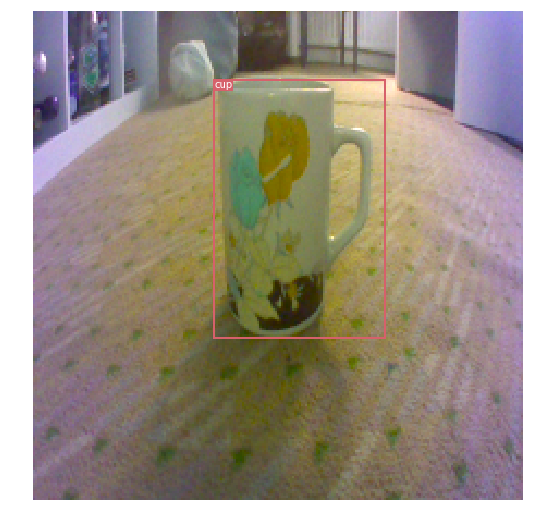

In [13]:
loop_counter=0
going_forward=False
import traceback

try:
    while True:
        loop_counter+=1
        image=camera.value
        detections=update({'new':image})  
        if detections:
            print(detections)
        if loop_counter==10000 or detections:
            car.throttle=0
            find_object('cup',Image.fromarray(image),selection='object_only',visualize=True, style='box')
            
            break
except:
    car.throttle=0
    car.steering=0
    traceback.print_exc()
